In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv
/kaggle/input/subsubsubsub/sub_weighted-ensemble_0.971820.csv
/kaggle/input/subsubsubsub/first_try4 (1).csv


# Does target depend on interactions of features (or just features in isolation)?

# Do any features have special relationship with target (like form clear linear relationship)?

# Are there some very powerful features and/or weak features?

# If someone asks us to explain what affects the target, could we explain it clearly in a few sentences?

# Imports

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
import itertools
from catboost import CatBoostClassifier

# Загрузка данных

In [4]:
train=pd.read_csv("/kaggle/input/playground-series-s5e7/train.csv")
test=pd.read_csv("/kaggle/input/playground-series-s5e7/test.csv")
sample=pd.read_csv("/kaggle/input/playground-series-s5e7/sample_submission.csv")


# EDA(попытка)

In [4]:
counts = train['Personality'].value_counts()
n_ext = counts.get('Extrovert', 0)
n_int = counts.get('Introvert', 0)

# 2) If there are more extroverts, drop the excess
if n_ext > n_int:
    # how many extroverts to remove
    excess = n_ext - n_int
    
    # randomly sample that many extrovert‐rows to drop
    drop_idx = (
        train[train['Personality'] == 'Extrovert']
        .sample(n=excess, random_state=42)
        .index
    )
    train = train.drop(index=drop_idx)
    

# 3) Check you’re now balanced
print(train['Personality'].value_counts())

Personality
Extrovert    4825
Introvert    4825
Name: count, dtype: int64


In [5]:
import pandas as pd

# 1) Identify numeric features (exclude identifiers/target if present)
num_feats = [
    c for c in train.select_dtypes(include=['number']).columns
    if c not in ('id', 'Personality_num')  # drop these if they exist
]

# 2) Compute IQR bounds for each feature
bounds = {}
for f in num_feats:
    q1 = train[f].quantile(0.25)
    q3 = train[f].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    bounds[f] = (lower, upper)

# 3) Build a mask that’s True only for rows within all bounds
mask = pd.Series(True, index=train.index)
for f, (low, high) in bounds.items():
    mask &= train[f].between(low, high)

# 4) Drop all rows with any outlier in any numeric feature
train_clean = train[mask].reset_index(drop=True)

print(f"Dropped {len(train) - len(train_clean)} rows; remaining {len(train_clean)} rows.")


Dropped 6783 rows; remaining 11741 rows.


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


In [6]:
train=train_clean

In [5]:
train.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


In [7]:
drop_cols=["id"]

In [8]:
num_feats=train.select_dtypes(include="number").drop(columns=drop_cols, errors='ignore').columns.tolist()
cat_feats=train.select_dtypes(include="object").drop(columns=drop_cols, errors='ignore').columns.tolist()

In [8]:
all_feats=num_feats+cat_feats

In [26]:
all_feats

['Time_spent_Alone',
 'Social_event_attendance',
 'Going_outside',
 'Friends_circle_size',
 'Post_frequency',
 'Stage_fear',
 'Drained_after_socializing',
 'Personality']

In [9]:
num_feats

['Time_spent_Alone',
 'Social_event_attendance',
 'Going_outside',
 'Friends_circle_size',
 'Post_frequency']

<Figure size 640x480 with 0 Axes>

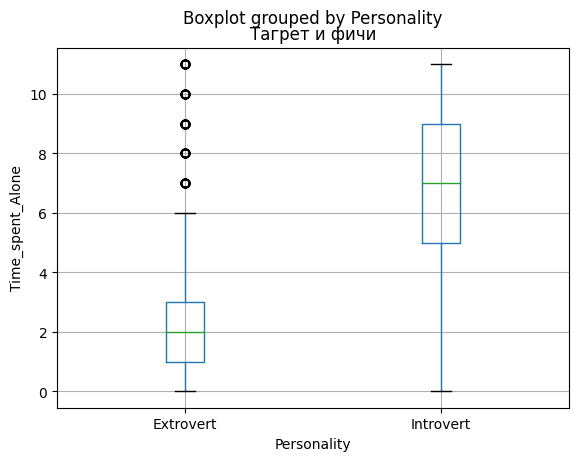

<Figure size 640x480 with 0 Axes>

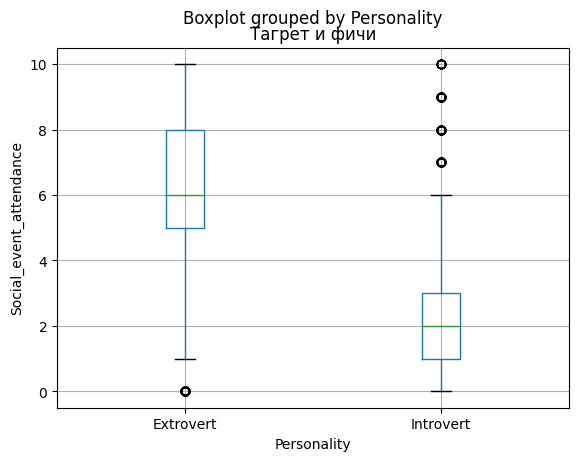

<Figure size 640x480 with 0 Axes>

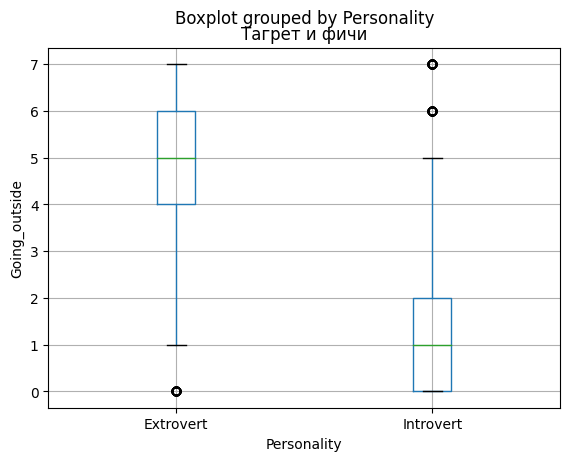

<Figure size 640x480 with 0 Axes>

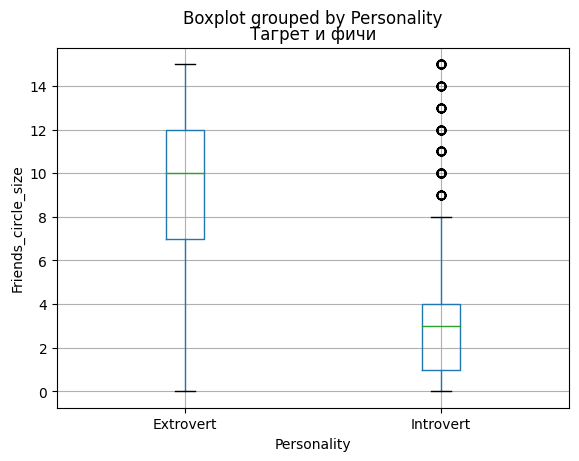

<Figure size 640x480 with 0 Axes>

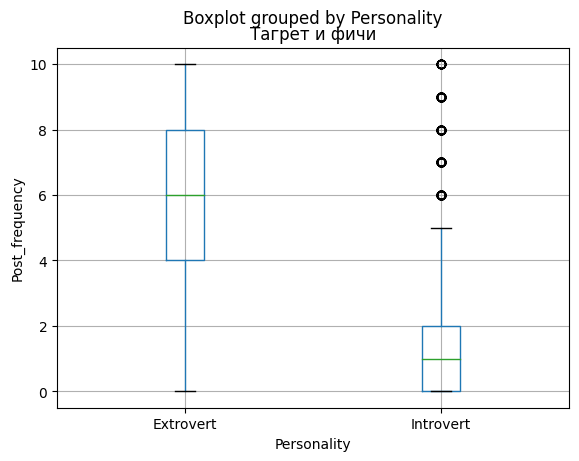

In [10]:
for feat in num_feats:
    plt.figure()
    train.boxplot(column=feat, by="Personality")
    plt.title("Тагрет и фичи")
    plt.xlabel('Personality')
    plt.ylabel(feat)
    plt.show()

<Figure size 640x480 with 0 Axes>

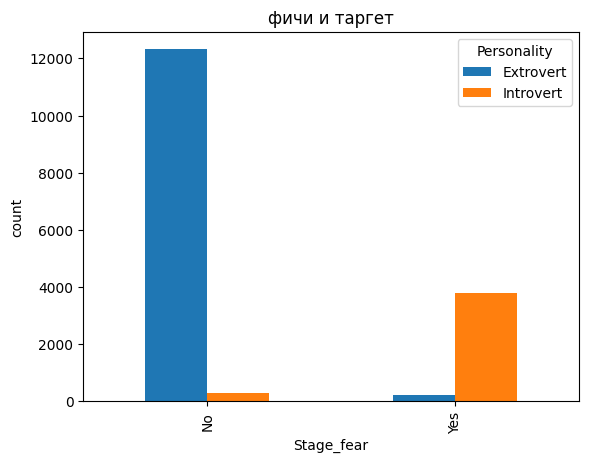

<Figure size 640x480 with 0 Axes>

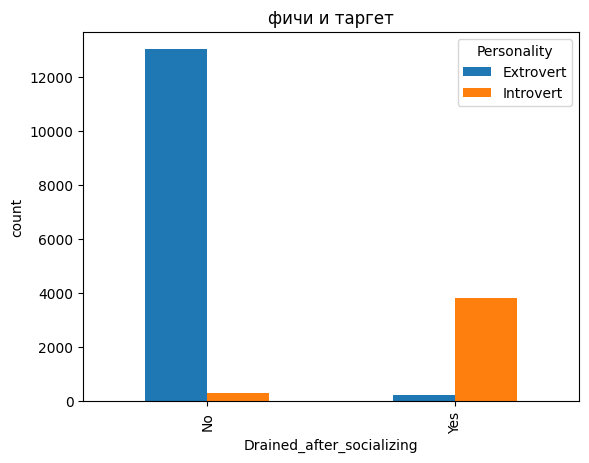

<Figure size 640x480 with 0 Axes>

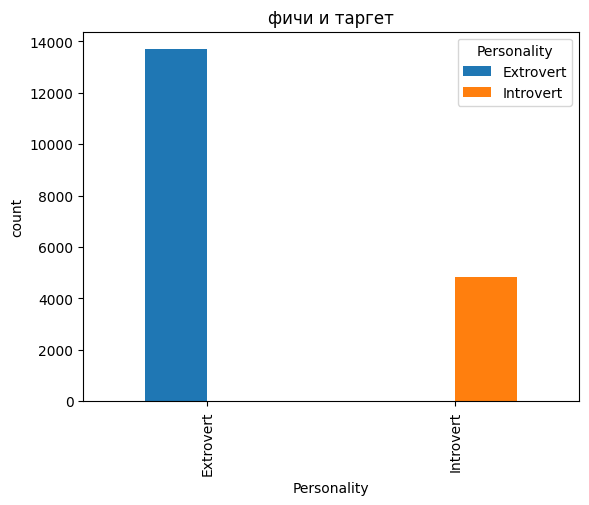

In [13]:
for feat in cat_feats:
    plt.figure()
    ct=pd.crosstab(train[feat], train['Personality'])
    ct.plot(kind='bar', legend=True)
    plt.title("фичи и таргет")
    #plt.labelx('Personality')
    plt.xlabel(feat)
    plt.ylabel('count')
    #plt.tight_layout()
    plt.show()

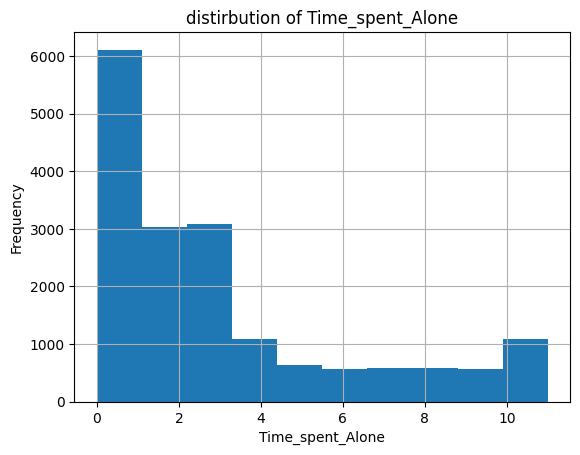

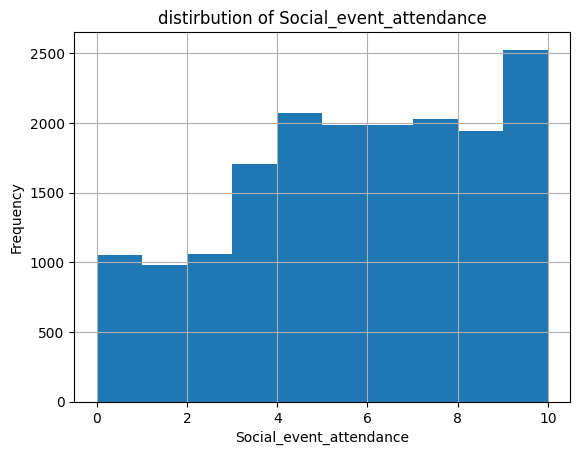

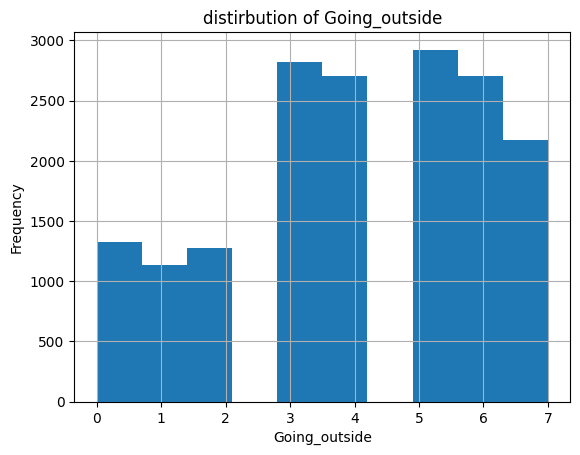

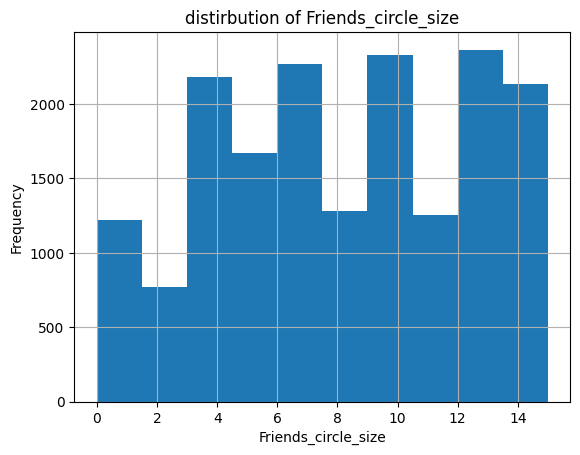

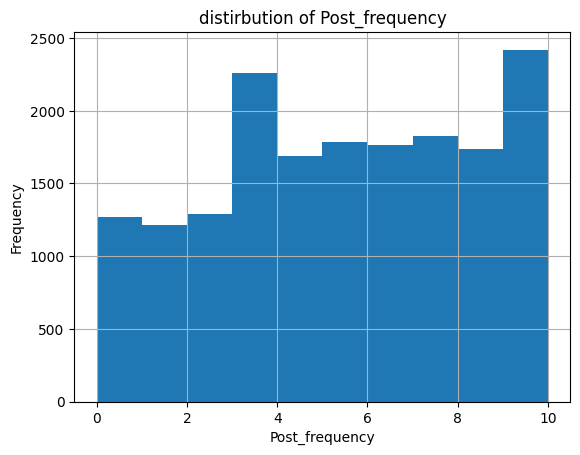

In [13]:
for feat in num_feats:
    plt.figure()
    train[feat].hist()
    plt.title(f"distirbution of {feat}")
    plt.xlabel(feat)
    plt.ylabel('Frequency')
    plt.show()

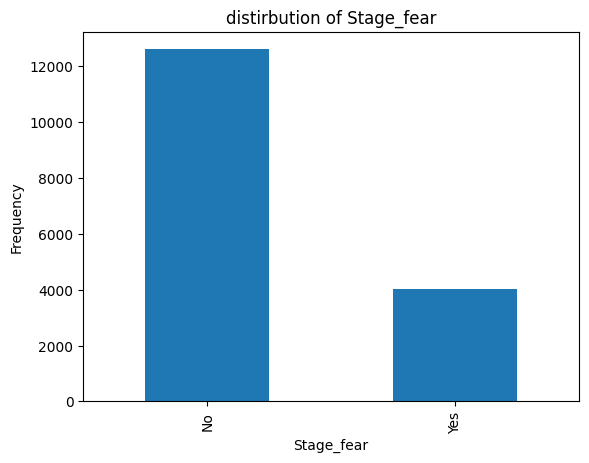

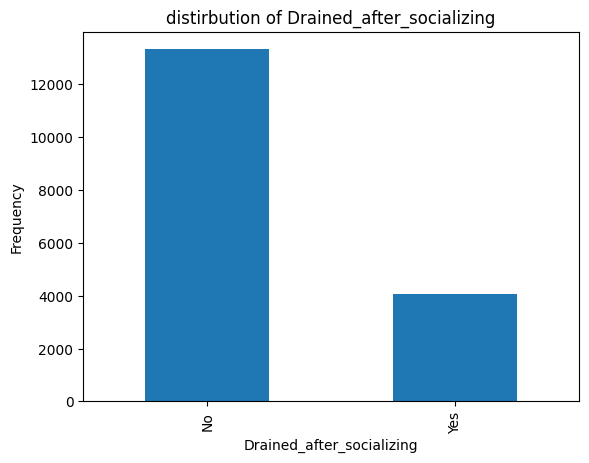

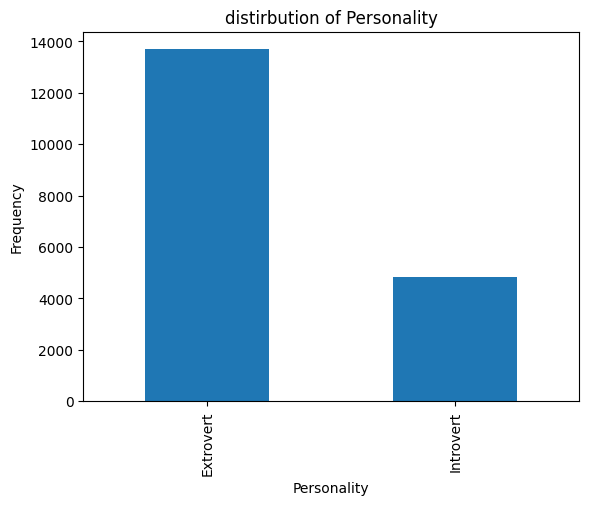

In [15]:
for feat in cat_feats:
    plt.figure()
    train[feat].value_counts().plot(kind='bar')
    plt.title(f"distirbution of {feat}")
    plt.xlabel(feat)
    plt.ylabel('Frequency')
    plt.show()
    

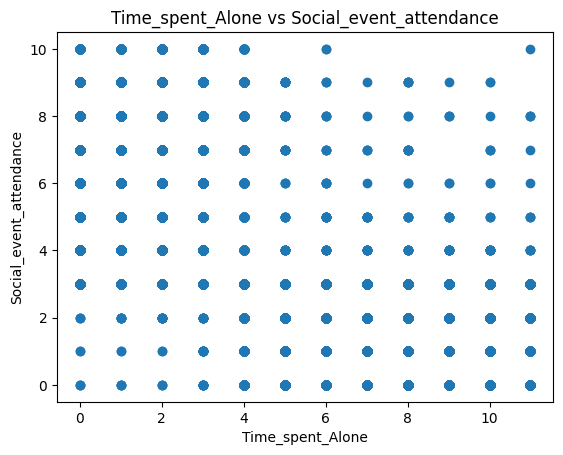

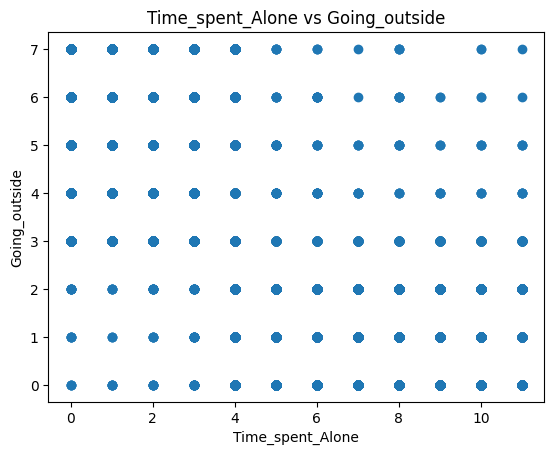

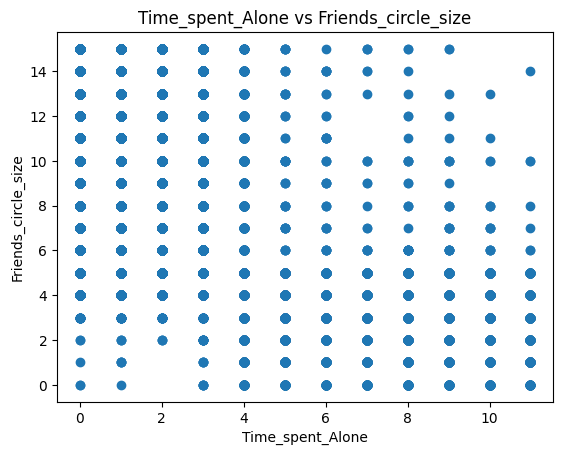

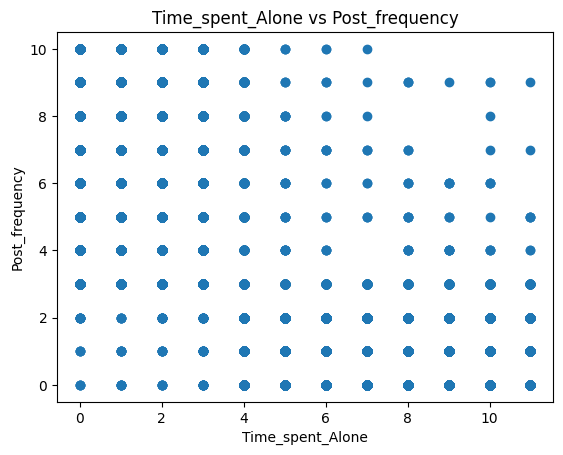

TypeError: 'value' must be an instance of str or bytes, not a float

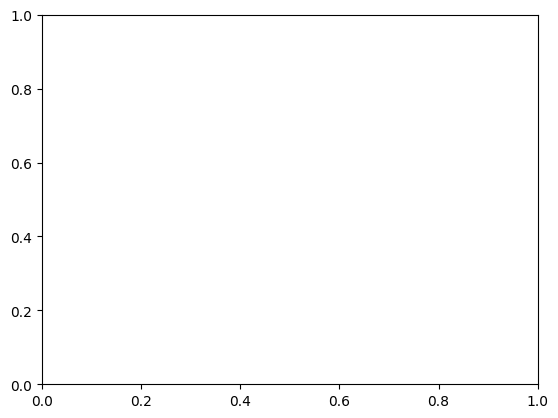

In [12]:
for feat1, feat2 in itertools.combinations(all_feats, 2):
    plt.figure()
    plt.scatter(train[feat1], train[feat2])
    plt.title(f"{feat1} vs {feat2}")
    plt.xlabel(feat1)
    plt.ylabel(feat2)
    plt.show()

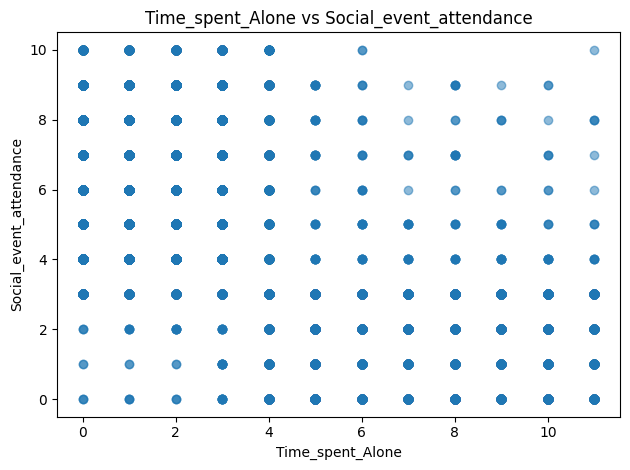

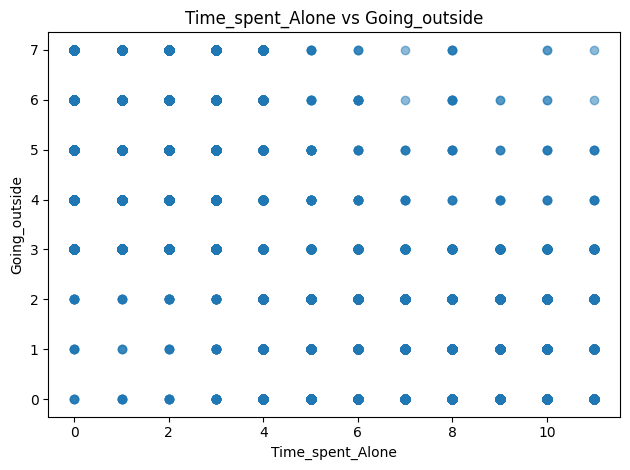

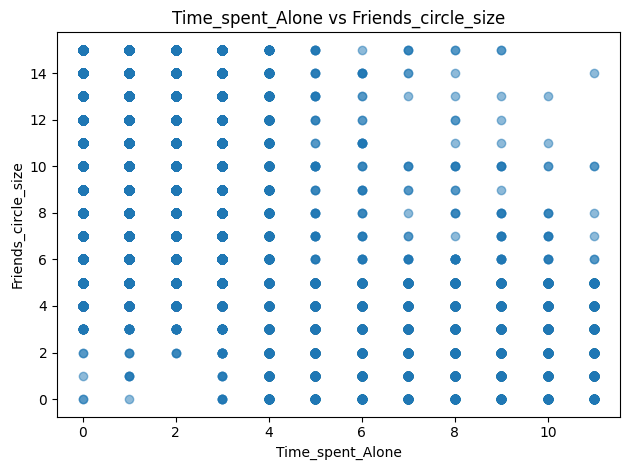

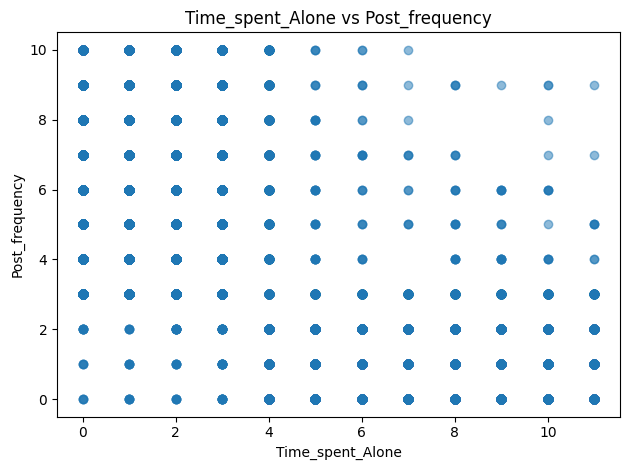

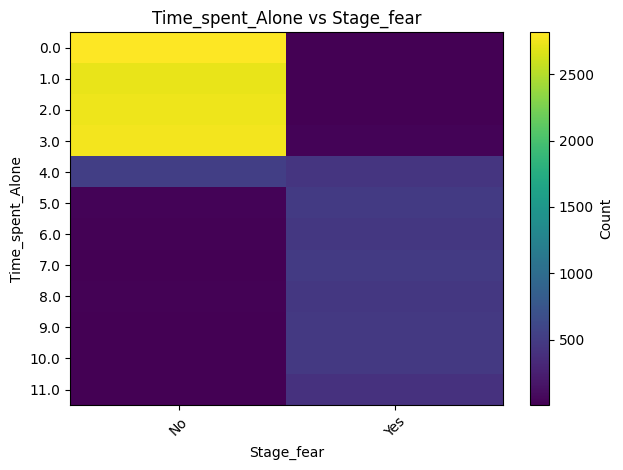

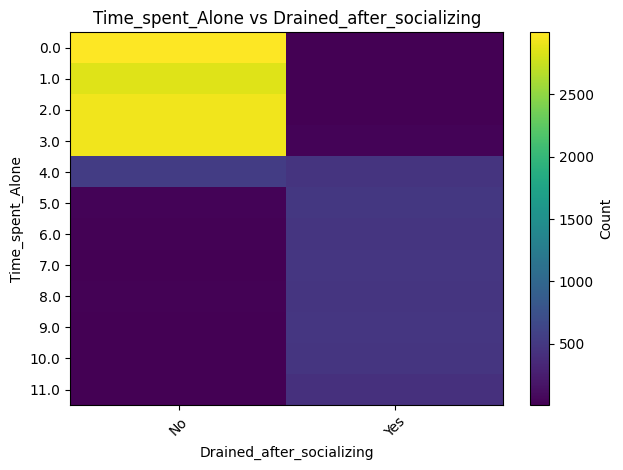

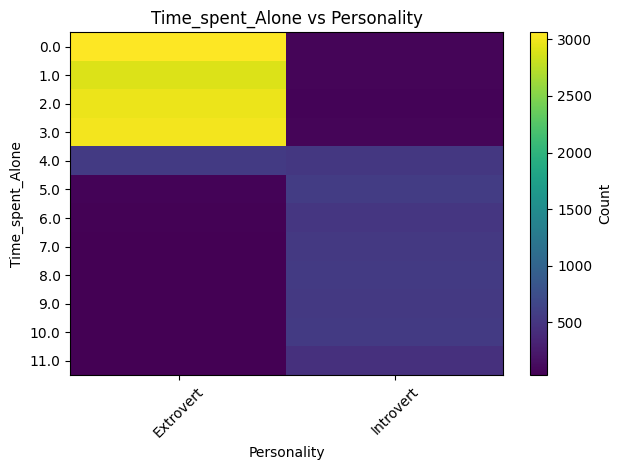

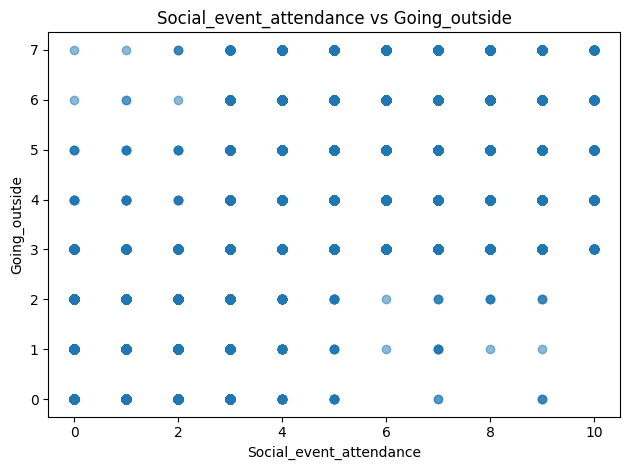

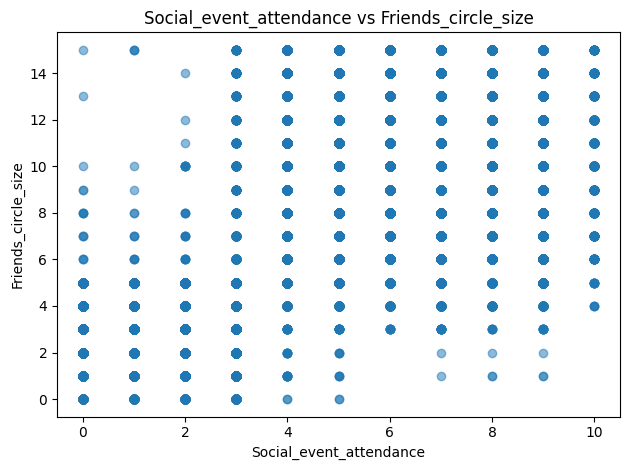

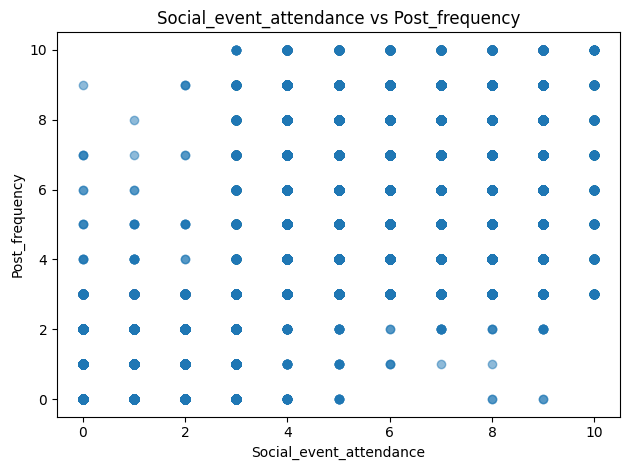

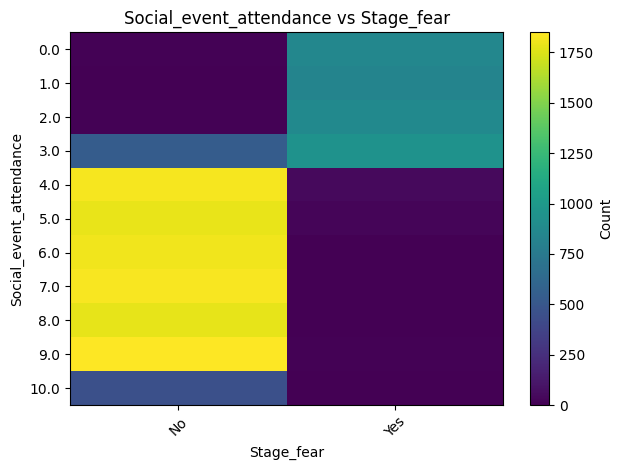

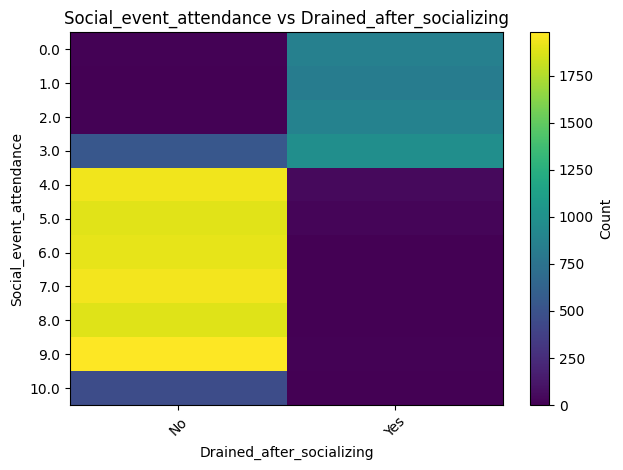

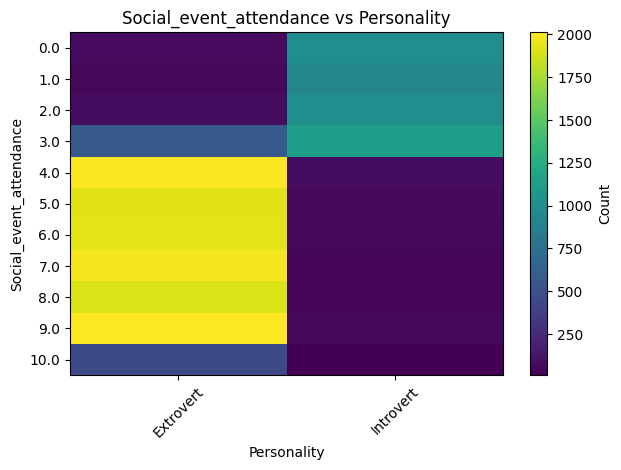

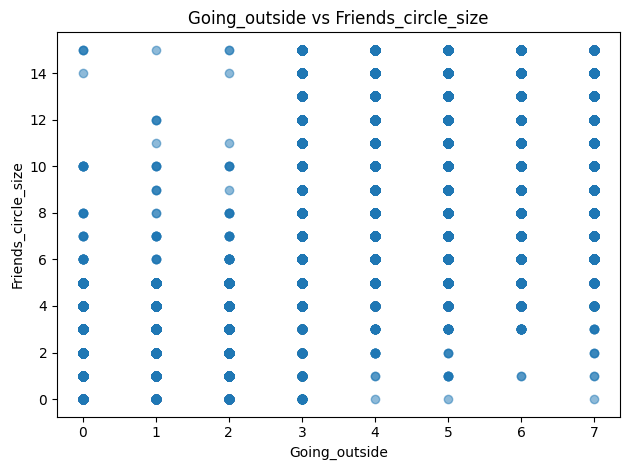

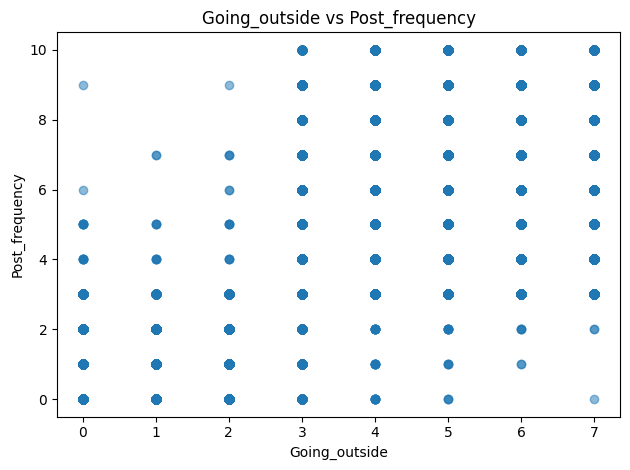

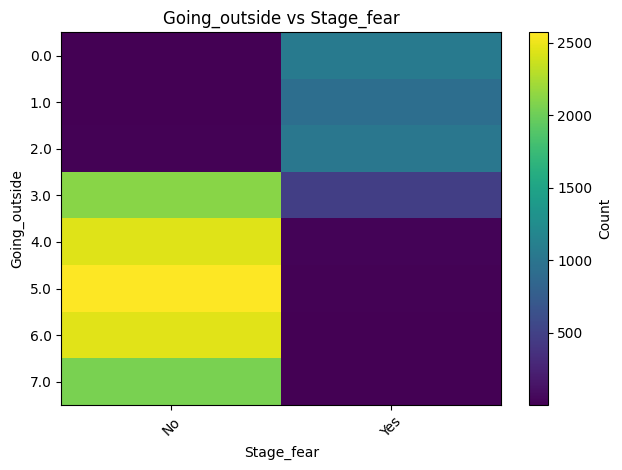

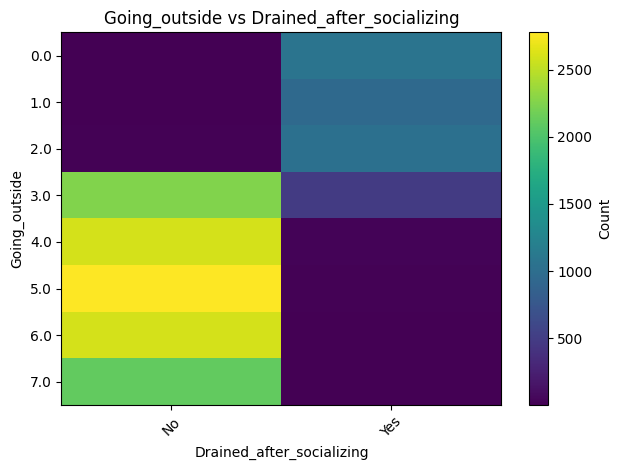

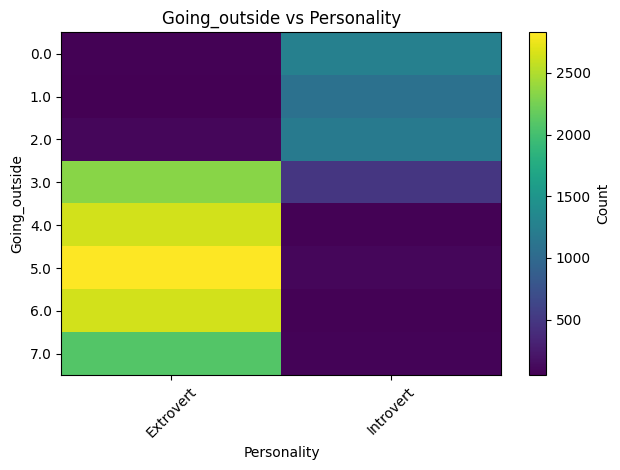

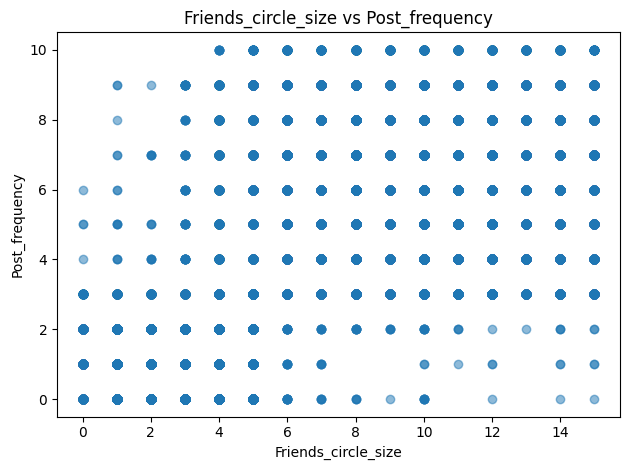

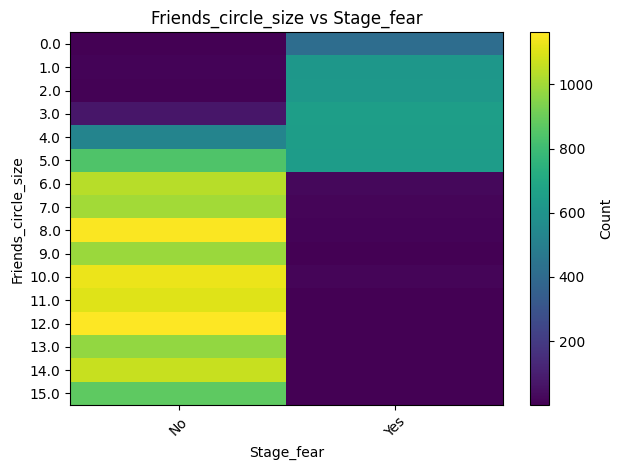

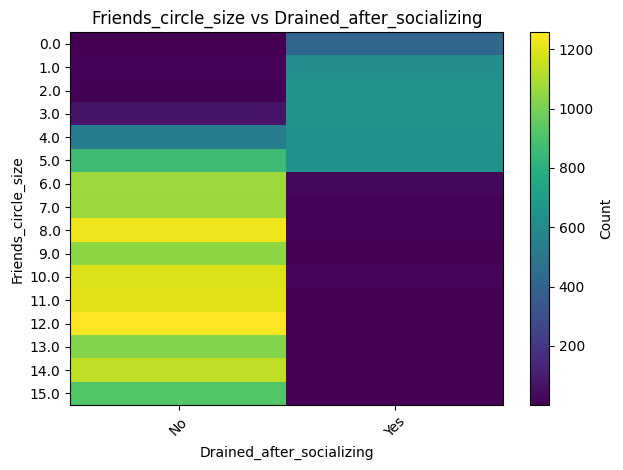

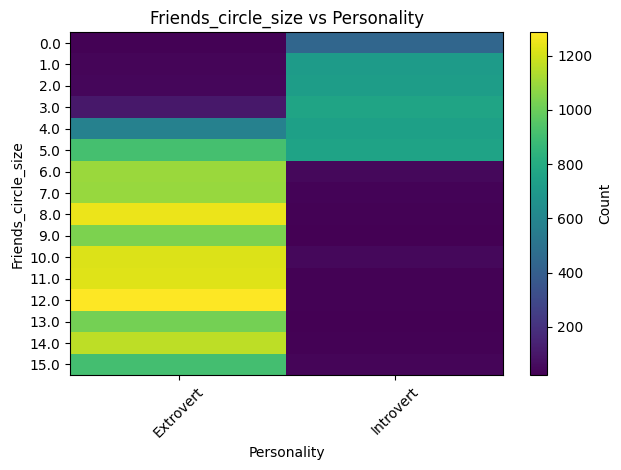

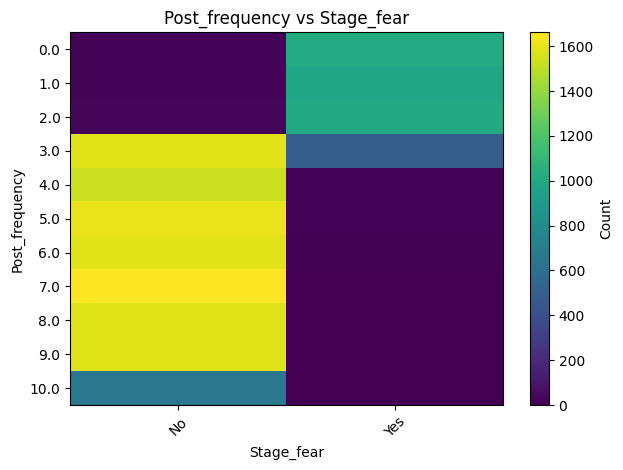

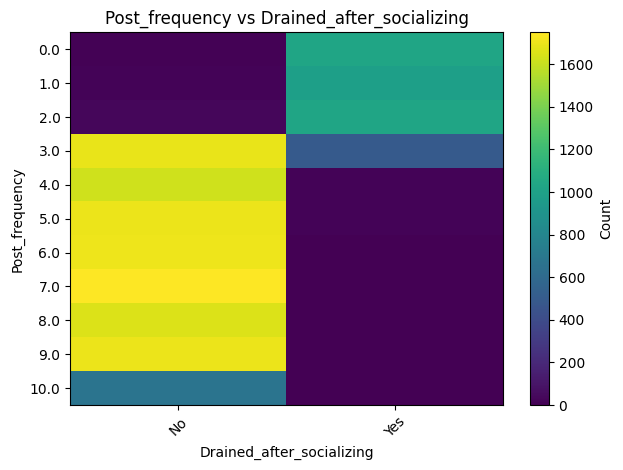

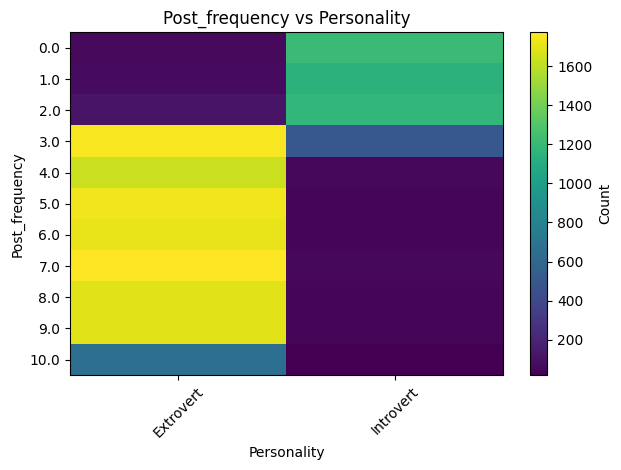

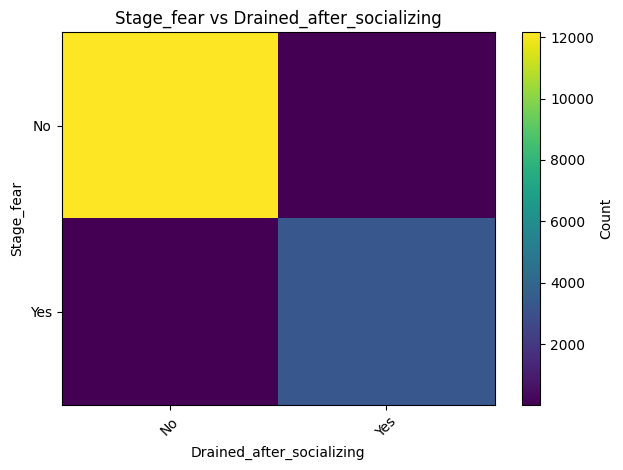

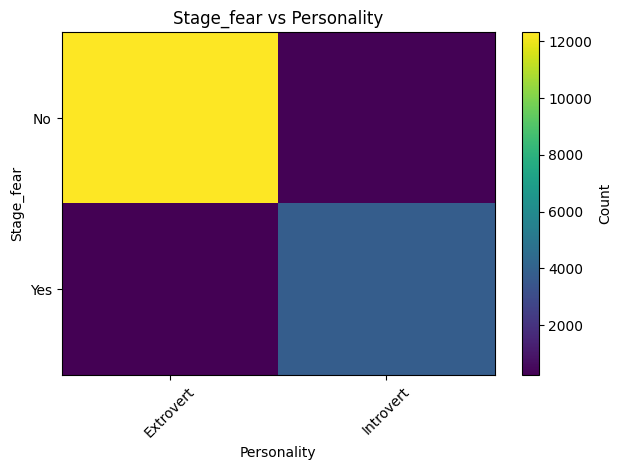

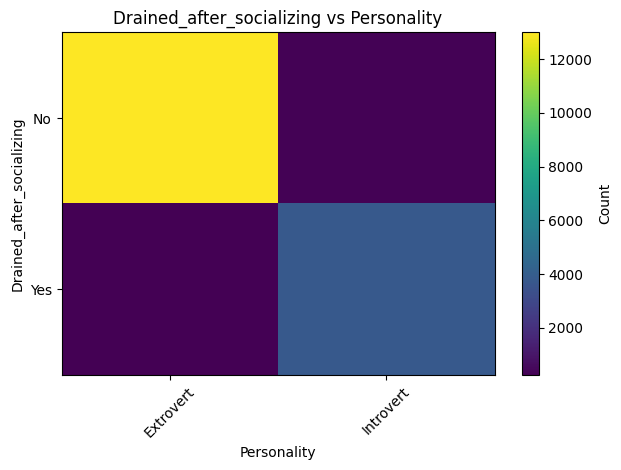

In [11]:
for f1, f2 in itertools.combinations(all_feats, 2):
    fig, ax = plt.subplots()
    
    # both numeric → scatter
    if f1 in num_feats and f2 in num_feats:
        ax.scatter(train[f1], train[f2], alpha=0.5)
        ax.set_xlabel(f1); ax.set_ylabel(f2)
    
    # numeric vs categorical → “jittered” scatter
   
    
    # both categorical → heatmap of counts
    else:
        ct = pd.crosstab(train[f1], train[f2])
        im = ax.imshow(ct, aspect='auto')
        # set ticks/labels
        ax.set_xticks(np.arange(ct.shape[1])); ax.set_xticklabels(ct.columns, rotation=45)
        ax.set_yticks(np.arange(ct.shape[0])); ax.set_yticklabels(ct.index)
        fig.colorbar(im, ax=ax, label='Count')
        ax.set_xlabel(f2); ax.set_ylabel(f1)
    
    ax.set_title(f"{f1} vs {f2}")
    fig.tight_layout()
    plt.show()

In [14]:
df = train.copy()

# 2) Identify and convert binary categorical columns
#    (adjust the list if you have other Yes/No fields)
bin_cats = ['Drained_after_socializing', 'Stage_fear']
for col in bin_cats:
    df[col] = df[col].map({'Yes':1, 'No':0})

# 3) Encode target: Extrovert→0, Introvert→1
df['Personality_num'] = df['Personality'].map({'Extrovert':0, 'Introvert':1})

# 4) Select only the numeric columns (this now includes your converted binaries)
#    and drop any identifier columns you don’t want in the corr matrix
num_cols = df.select_dtypes(include=['number']).columns.tolist()
for drop in ['id', 'Personality_num']:
    if drop in num_cols: num_cols.remove(drop)

# 5) Compute the full correlation matrix
corr_matrix = df[num_cols + ['Personality_num']].corr()

# 6) View it
print("── Full correlation matrix ──")
print(corr_matrix)

# 7) And just the target‐feature correlations
print("\n── Correlation with Personality ──")
print(corr_matrix['Personality_num']
      .drop('Personality_num')
      .sort_values(ascending=False))

── Full correlation matrix ──
                           Time_spent_Alone  Stage_fear  \
Time_spent_Alone                   1.000000    0.826171   
Stage_fear                         0.826171    1.000000   
Social_event_attendance           -0.628806   -0.748626   
Going_outside                     -0.640884   -0.762526   
Drained_after_socializing          0.825065    0.994666   
Friends_circle_size               -0.598014   -0.697489   
Post_frequency                    -0.611544   -0.720640   
Personality_num                    0.776725    0.913407   

                           Social_event_attendance  Going_outside  \
Time_spent_Alone                         -0.628806      -0.640884   
Stage_fear                               -0.748626      -0.762526   
Social_event_attendance                   1.000000       0.585224   
Going_outside                             0.585224       1.000000   
Drained_after_socializing                -0.744242      -0.759017   
Friends_circle_size     

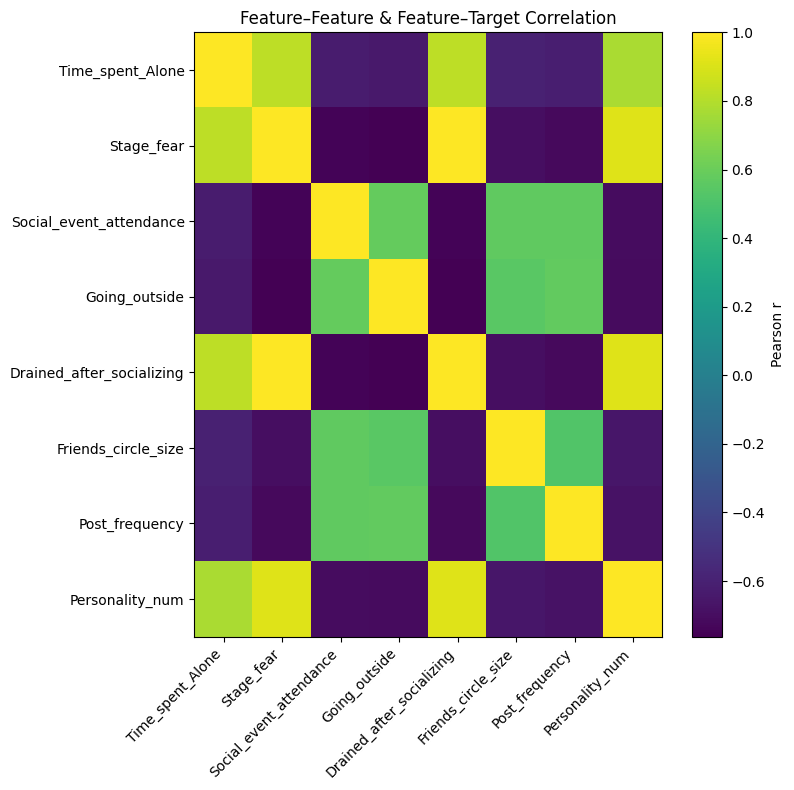

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Prepare the data (repeat your mapping steps)
df = train.copy()

# Binary‐encode the Yes/No columns
for col in ['Stage_fear', 'Drained_after_socializing']:
    df[col] = df[col].map({'Yes':1, 'No':0})

# Encode target as numeric
df['Personality_num'] = df['Personality'].map({'Extrovert':0, 'Introvert':1})

# Select only numeric columns, drop id
num_cols = df.select_dtypes(include=['number']).columns.drop(['id'], errors='ignore')

# 2) Compute correlation matrix
corr = df[num_cols].corr()

# 3) Plot heatmap
fig, ax = plt.subplots(figsize=(8,8))
cax = ax.imshow(corr, aspect='auto')
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticks(np.arange(len(corr.index)))
ax.set_yticklabels(corr.index)
fig.colorbar(cax, label='Pearson r')
ax.set_title("Feature–Feature & Feature–Target Correlation")
fig.tight_layout()
plt.show()


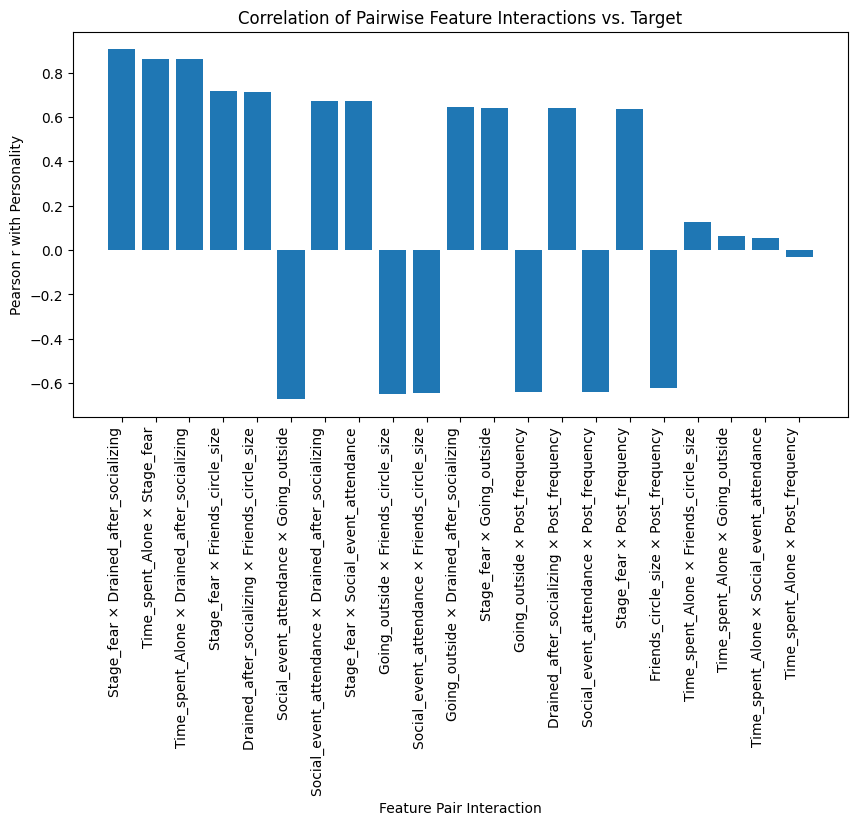

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

# --------------------------------------
# 1) Prepare your DataFrame
# --------------------------------------
df = train.copy()

# map Personality → numeric
df['Personality_num'] = df['Personality'].map({'Extrovert': 0, 'Introvert': 1})
test['Personality_num'] = test['Personality'].map({'Extrovert': 0, 'Introvert': 1})

# map the two binary categoricals to 0/1
for col in ['Stage_fear', 'Drained_after_socializing']:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# --------------------------------------
# 2) Identify your numeric features
# --------------------------------------
num_feats = [
    c for c in df.select_dtypes(include=['number']).columns
    if c not in ['id', 'Personality_num']
]

# --------------------------------------
# 3) Compute interaction correlations
# --------------------------------------
records = []
for f1, f2 in itertools.combinations(num_feats, 2):
    interaction = df[f1] * df[f2]
    corr_val = interaction.corr(df['Personality_num'])
    records.append({
        'pair': f"{f1} × {f2}",
        'corr': corr_val
    })

corr_df = pd.DataFrame(records)
corr_df = corr_df.reindex(corr_df['corr'].abs().sort_values(ascending=False).index)

# --------------------------------------
# 4) Plot
# --------------------------------------
plt.figure(figsize=(10,5))
plt.bar(corr_df['pair'], corr_df['corr'])
plt.xticks(rotation=90, ha='right')
plt.xlabel('Feature Pair Interaction')
plt.ylabel('Pearson r with Personality')
plt.title('Correlation of Pairwise Feature Interactions vs. Target')
#plt.tight_layout()
plt.show()


In [18]:
corr_df

,pair,corr
8,Stage_fear × Drained_after_socializing,0.905467
0,Time_spent_Alone × Stage_fear,0.861535
3,Time_spent_Alone × Drained_after_socializing,0.860923
9,Stage_fear × Friends_circle_size,0.717417
18,Drained_after_socializing × Friends_circle_size,0.714638
11,Social_event_attendance × Going_outside,-0.672185
12,Social_event_attendance × Drained_after_social...,0.671694
6,Stage_fear × Social_event_attendance,0.670435
16,Going_outside × Friends_circle_size,-0.647715
13,Social_event_attendance × Friends_circle_size,-0.643108


# Feature engineering

## Заполнение нанов

In [9]:
train[num_feats] = train[num_feats].apply(
    lambda col: col.fillna(col.mode().iloc[0])
)

In [10]:
test[num_feats] = test[num_feats].apply(
    lambda col: col.fillna(col.mode().iloc[0])
)

In [11]:
train[cat_feats] = train[cat_feats].apply(
    lambda col: col.fillna(col.mode().iloc[0])
)

In [12]:
cat2_feats=test.select_dtypes(include="object").drop(columns=drop_cols, errors='ignore').columns.tolist()

In [13]:
test[cat2_feats] = test[cat2_feats].apply(
    lambda col: col.fillna(col.mode().iloc[0])
)

## Фичи

In [14]:
import numpy as np
import pandas as pd
df = train.copy()
# 1) Identify your base numeric features
base_num_feats = [
    c for c in df.select_dtypes(include='number').columns
    if c not in ('id', 'Personality_num') and '_x_' not in c and not c.startswith('PC')
]

# 2) Define a safe log1p function that shifts negatives
def safe_log1p(series):
    min_val = series.min()
    if min_val <= -1:
        # shift so that the smallest point is just above -1 → zero after adding 1
        shift = abs(min_val) + 1.0001
    elif min_val < 0:
        # if between -1 and 0, shift so min == 0
        shift = abs(min_val)
    else:
        shift = 0.0
    return np.log1p(series + shift)

# 3) Apply to train and test
for f in base_num_feats:
    df[f]      = safe_log1p(df[f])
    test[f] = safe_log1p(test[f])

print("Applied log1p transform to:", base_num_feats)


Applied log1p transform to: ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']


In [15]:
import pandas as pd
import numpy as np
import itertools

# 1) Copy & preprocess
#df = train.copy()
df = train.copy()
# Binary‑encode the two Yes/No flags
for col in ['Stage_fear', 'Drained_after_socializing']:
    df[col] = df[col].map({'Yes':1, 'No':0})
for col in ['Stage_fear', 'Drained_after_socializing']:
    test[col] = test[col].map({'Yes':1, 'No':0})

#for col in ['Stage_fear', 'Drained_after_socializing']:
#    df=df.drop(columns=col)
#for col in ['Stage_fear', 'Drained_after_socializing']:
#    test=test.drop(columns=col)

# Encode target (so corr() works)
df['Personality_num'] = df['Personality'].map({'Extrovert':0, 'Introvert':1})
#test['Personality_num'] = test['Personality'].map({'Extrovert': 0, 'Introvert': 1})

# 2) Identify numeric features (exclude id & target)
for f in num_feats:
    df[f'{f}_2']      = df[f] ** 2
    test[f'{f}_2'] = test[f] ** 2

    df[f'{f}_3']      = df[f] ** 3
    test[f'{f}_3'] = test[f] ** 3

# 4) Recompute the full numeric feature list (including the new ones)
all_num_feats = [
    c for c in df.select_dtypes(include='number').columns 
    if c not in ('id','Personality_num')
]

# 5) Find pairwise interactions whose |corr| > threshold
records = []
for f1, f2 in itertools.combinations(all_num_feats, 2):
    interaction = df[f1] * df[f2]
    r = interaction.corr(df['Personality_num'])
    records.append((f1, f2, r))

corr_df = pd.DataFrame(records, columns=['f1','f2','r'])
threshold = 0.6
good = corr_df[corr_df['r'].abs() > threshold]

# 6) Add those interactions to both train and test
for _, row in good.iterrows():
    f1, f2 = row['f1'], row['f2']
    new_col = f"{f1}_x_{f2}"
    df[new_col]      = df[f1] * df[f2]
    test[new_col] = test[f1] * test[f2]

# 7) Report what was added
print("Added squares and cubes for:", num_feats)
print("Added interaction features:", [
    f"{r['f1']}_x_{r['f2']}" for _, r in good.iterrows()
])

Added squares and cubes for: ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
Added interaction features: ['Time_spent_Alone_x_Stage_fear', 'Time_spent_Alone_x_Drained_after_socializing', 'Time_spent_Alone_x_Time_spent_Alone_2', 'Time_spent_Alone_x_Time_spent_Alone_3', 'Stage_fear_x_Drained_after_socializing', 'Stage_fear_x_Time_spent_Alone_2', 'Stage_fear_x_Time_spent_Alone_3', 'Drained_after_socializing_x_Friends_circle_size', 'Drained_after_socializing_x_Time_spent_Alone_2', 'Drained_after_socializing_x_Time_spent_Alone_3', 'Time_spent_Alone_2_x_Time_spent_Alone_3']


In [16]:
import pandas as pd
import numpy as np
import itertools

# 1) Copy & preprocess


# 2) Identify numeric features (exclude id & target)
num_feats = [
    c for c in df.select_dtypes(include='number').columns 
    if c not in ('id','Personality_num')
]

# 3) Find all pairwise correlations (reuse your existing code)


# 4) Find all **triple** correlations
triple_records = []
for f1, f2, f3 in itertools.combinations(num_feats, 3):
    inter = df[f1] * df[f2] * df[f3]
    r = inter.corr(df['Personality_num'])
    triple_records.append((f1, f2, f3, r))
triple_corr_df = pd.DataFrame(triple_records, columns=['f1','f2','f3','r'])
triple_good = triple_corr_df[triple_corr_df['r'].abs() > 0.6]

# 5) Add selected pairwise features
#for _, row in pair_good.iterrows():
#    f1, f2 = row['f1'], row['f2']
 #   new_col = f"{f1}_x_{f2}"
 #   df[new_col]      = df[f1] * df[f2]
  #  test_df[new_col] = test_df[f1] * test_df[f2]
#
# 6) Add selected triple features
for _, row in triple_good.iterrows():
    f1, f2, f3 = row['f1'], row['f2'], row['f3']
    new_col = f"{f1}_x_{f2}_x_{f3}"
    df[new_col]      = df[f1] * df[f2] * df[f3]
    test[new_col] = test[f1] * test[f2] * test[f3]



print("\nAdded triple interactions:")
print(triple_good.assign(col=lambda d: d['f1']+'_x_'+d['f2']+'_x_'+d['f3'])['col'].tolist())

# Now df and test_df contain your original + new interaction features



Added triple interactions:
['Time_spent_Alone_x_Stage_fear_x_Drained_after_socializing', 'Time_spent_Alone_x_Stage_fear_x_Time_spent_Alone_2', 'Time_spent_Alone_x_Stage_fear_x_Time_spent_Alone_x_Stage_fear', 'Time_spent_Alone_x_Stage_fear_x_Stage_fear_x_Drained_after_socializing', 'Time_spent_Alone_x_Stage_fear_x_Stage_fear_x_Time_spent_Alone_2', 'Time_spent_Alone_x_Drained_after_socializing_x_Time_spent_Alone_2', 'Time_spent_Alone_x_Drained_after_socializing_x_Time_spent_Alone_x_Drained_after_socializing', 'Time_spent_Alone_x_Drained_after_socializing_x_Stage_fear_x_Drained_after_socializing', 'Time_spent_Alone_x_Drained_after_socializing_x_Drained_after_socializing_x_Time_spent_Alone_2', 'Stage_fear_x_Drained_after_socializing_x_Time_spent_Alone_x_Stage_fear', 'Stage_fear_x_Drained_after_socializing_x_Time_spent_Alone_x_Drained_after_socializing', 'Stage_fear_x_Drained_after_socializing_x_Stage_fear_x_Drained_after_socializing', 'Stage_fear_x_Time_spent_Alone_2_x_Time_spent_Alone_x_

In [17]:
df['log_Alone'] = np.log1p(df['Time_spent_Alone'])
df['social_ratio'] = df['Social_event_attendance'] / (df['Going_outside'] + 1)
df['friends_per_post'] = df['Friends_circle_size'] / (df['Post_frequency'] + 1)
df['Alone_sq'] = df['Time_spent_Alone']**2
df['Alone_cu'] = df['Time_spent_Alone']**3

test['log_Alone'] = np.log1p(test['Time_spent_Alone'])
test['social_ratio'] = test['Social_event_attendance'] / (test['Going_outside'] + 1)
test['friends_per_post'] = test['Friends_circle_size'] / (test['Post_frequency'] + 1)
test['Alone_sq'] = test['Time_spent_Alone']**2
test['Alone_cu'] = test['Time_spent_Alone']**3

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1) Identify the original numeric features (exclude interactions & id/target)
base_num_feats = [
    c for c in df.select_dtypes(include='number').columns
    if c not in ('id','Personality_num') 
    #and '_x_' not in c
]

# 2) Standardize
scaler = StandardScaler()
X_train_num = scaler.fit_transform(df[base_num_feats])
X_test_num  = scaler.transform(test[base_num_feats])

# 3) Fit PCA
n_components = 5
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_num)
X_test_pca  = pca.transform(X_test_num)

# 4) Append to df & test_df
for i in range(n_components):
    comp_name = f"PC{i+1}"
    df[comp_name]      = X_train_pca[:, i]
    test[comp_name] = X_test_pca[:, i]

print(f"Appended {n_components} PCA features:", [f"PC{i+1}" for i in range(n_components)])


Appended 5 PCA features: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']


In [18]:
df=df.drop(columns='Personality')

In [20]:
df

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality_num,Time_spent_Alone_2,...,Post_frequency_x_Friends_circle_size_2,Time_spent_Alone_2_x_Time_spent_Alone_3,Social_event_attendance_2_x_Going_outside_2,Social_event_attendance_2_x_Friends_circle_size_2,Going_outside_2_x_Friends_circle_size_2,PC1,PC2,PC3,PC4,PC5
0,0,0.000000,0,1.945910,1.609438,0,2.772589,1.791759,0,0.000000,...,13.773700,0.000000,9.808306,29.108275,19.912205,-3.024753,-0.655694,2.649661,2.022682,1.391208
1,1,0.693147,0,2.079442,1.386294,0,2.397895,2.197225,0,0.480453,...,12.633825,0.160003,8.310064,24.863019,11.050230,-2.435249,-1.049361,-0.773334,3.308039,-0.969464
2,2,1.945910,1,0.693147,0.000000,0,1.386294,0.000000,1,3.786566,...,0.000000,27.900624,0.000000,0.923340,0.000000,12.416727,-2.315463,1.725114,1.223243,-0.131101
3,3,1.386294,0,2.079442,1.386294,0,2.484907,1.791759,0,1.921812,...,11.063687,5.120086,8.310064,26.700143,11.866730,-0.876066,0.234325,1.499900,2.500359,-1.003469
4,7,1.098612,0,2.197225,1.386294,0,1.609438,1.791759,0,1.206949,...,4.641177,1.600377,9.278116,12.505393,4.978051,0.720761,-2.697860,-0.498667,0.258499,-3.789995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11736,18514,1.945910,0,1.791759,1.386294,0,2.397895,1.609438,0,3.786566,...,9.254110,27.900624,6.169789,18.459496,11.050230,2.090275,1.498400,1.144147,1.706356,0.115062
11737,18518,1.386294,0,2.197225,1.386294,0,1.791759,2.197225,0,1.921812,...,7.053974,5.120086,9.278116,15.499165,6.169789,-0.468658,-1.006324,-2.552642,1.654500,-3.419607
11738,18519,1.386294,0,2.079442,1.386294,0,2.302585,2.079442,0,1.921812,...,11.024987,5.120086,8.310064,22.925816,10.189252,-1.139808,-0.004504,-0.660098,2.685670,-1.419704
11739,18520,0.693147,0,1.945910,2.079442,0,1.945910,1.791759,0,0.480453,...,6.784616,0.160003,16.373405,14.338084,16.373405,-2.174223,-1.270723,-0.382758,-3.597928,-0.262143


# Бейзлайн

In [ ]:
drop_cols=["id", ]

In [36]:
num_feats=df.select_dtypes(include="number").drop(columns=drop_cols, errors='ignore').columns.tolist()
cat_feats=df.select_dtypes(include="object").drop(columns=drop_cols, errors='ignore').columns.tolist()

In [38]:
cat_feats

[]

In [37]:
cat_feats

['Time_spent_Alone',
 'Stage_fear',
 'Social_event_attendance',
 'Going_outside',
 'Drained_after_socializing',
 'Friends_circle_size',
 'Post_frequency',
 'Personality_num',
 'Time_spent_Alone_x_Stage_fear',
 'Time_spent_Alone_x_Drained_after_socializing',
 'Stage_fear_x_Social_event_attendance',
 'Stage_fear_x_Drained_after_socializing',
 'Stage_fear_x_Friends_circle_size',
 'Stage_fear_x_Post_frequency',
 'Social_event_attendance_x_Going_outside',
 'Social_event_attendance_x_Drained_after_socializing',
 'Social_event_attendance_x_Friends_circle_size',
 'Social_event_attendance_x_Post_frequency',
 'Going_outside_x_Friends_circle_size',
 'Going_outside_x_Post_frequency',
 'Drained_after_socializing_x_Friends_circle_size',
 'Drained_after_socializing_x_Post_frequency',
 'Friends_circle_size_x_Post_frequency']

In [19]:
X=df.drop(columns='Personality_num')
y=df['Personality_num']
X_train, X_val, y_train, y_val=train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

In [22]:
model=CatBoostClassifier(
    iterations=1000,
    depth=4,
    learning_rate=0.01,
    verbose=100,
    eval_metric='BalancedAccuracy',
    loss_function='Logloss',
    #task_type="GPU",
    #device="0"
    random_seed=42, 
    
)

In [20]:
from catboost import CatBoostClassifier

# your tuned params
cb_params = {
    "border_count": 39,
    "colsample_bylevel": 0.19459088572914465,
    "depth": 2,
    "iterations": 1467,
    "l2_leaf_reg": 31.236169478676036,
    "learning_rate": 0.06852669420904771,
    "min_data_in_leaf": 160,         # renamed from min_child_samples
    "random_seed": 42,               # renamed from random_state
    "random_strength": 0.8517786189616939,
    "scale_pos_weight": 1.1691394390533685,
    "subsample": 0.3192330024411618,
    "border_count": 39,
    "verbose": 100,
   # "cat_features": cat_cols
}

model = CatBoostClassifier(
    **cb_params,
    eval_metric='BalancedAccuracy',
    loss_function='Logloss'
)

In [21]:
model.fit(X_train, y_train, eval_set=[(X_val, y_val)],early_stopping_rounds=500)

0:	learn: 0.9295730	test: 0.9332321	best: 0.9332321 (0)	total: 58.2ms	remaining: 1m 25s
100:	learn: 0.9334340	test: 0.9372934	best: 0.9372934 (6)	total: 467ms	remaining: 6.32s
200:	learn: 0.9333699	test: 0.9370374	best: 0.9372934 (6)	total: 868ms	remaining: 5.47s
300:	learn: 0.9340653	test: 0.9372934	best: 0.9372934 (6)	total: 1.28s	remaining: 4.96s
400:	learn: 0.9337496	test: 0.9372934	best: 0.9372934 (6)	total: 1.7s	remaining: 4.51s
500:	learn: 0.9343810	test: 0.9360308	best: 0.9372934 (6)	total: 2.1s	remaining: 4.05s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.9372934413
bestIteration = 6

Shrink model to first 7 iterations.


In [24]:
from catboost import cv, Pool
cv_data = cv(
    Pool(X, y),
    model.get_params(),
    fold_count=5,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.9302276	test: 0.9309279	best: 0.9309279 (0)	total: 5.01ms	remaining: 7.34s
100:	learn: 0.9343855	test: 0.9342562	best: 0.9355188 (19)	total: 384ms	remaining: 5.19s
200:	learn: 0.9343855	test: 0.9340001	best: 0.9355188 (19)	total: 762ms	remaining: 4.8s
300:	learn: 0.9345136	test: 0.9340001	best: 0.9355188 (19)	total: 1.16s	remaining: 4.51s
400:	learn: 0.9353370	test: 0.9324815	best: 0.9355188 (19)	total: 1.65s	remaining: 4.37s
500:	learn: 0.9353370	test: 0.9334881	best: 0.9355188 (19)	total: 2.09s	remaining: 4.03s
600:	learn: 0.9357167	test: 0.9334881	best: 0.9355188 (19)	total: 2.53s	remaining: 3.64s
700:	learn: 0.9360323	test: 0.9334881	best: 0.9355188 (19)	total: 2.99s	remaining: 3.26s
800:	learn: 0.9360964	test: 0.9334881	best: 0.9355188 (19)	total: 3.4s	remaining: 2.83s
900:	learn: 0.9360964	test: 0.9334881	best: 0.9355188 (19)	total: 3.81s	remaining: 2.39s
1000:	learn: 0.9361604	test: 0.9334881	best: 0.9355188 (19)	total: 4.23s	remaining: 1.97s
1

# Submission

In [39]:
sample

,id,Personality
0,18524,Extrovert
1,18525,Extrovert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Extrovert
...,...,...
6170,24694,Extrovert
6171,24695,Extrovert
6172,24696,Extrovert
6173,24697,Extrovert


In [22]:
sample['Personality']=model.predict(test)

In [22]:
sample

,id,Personality
0,18524,0
1,18525,1
2,18526,0
3,18527,0
4,18528,1
...,...,...
6170,24694,0
6171,24695,1
6172,24696,0
6173,24697,0


In [32]:
sample

,id,Personality
0,18524,0
1,18525,1
2,18526,0
3,18527,0
4,18528,1
...,...,...
6170,24694,0
6171,24695,1
6172,24696,0
6173,24697,0


In [23]:
sample['Personality'] = sample['Personality'].map({0:'Extrovert',1: 'Introvert'})

In [30]:
sample

,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert
...,...,...
6170,24694,Extrovert
6171,24695,Introvert
6172,24696,Extrovert
6173,24697,Extrovert


In [24]:
sample.to_csv('first_try7.csv', index=False)